![book header](pictures/header.png)

# Module 5: Navigating the KIIT

This chapter contains information that you will need when preparing for the second part: the final challenge. The ultimate goal is to let KITT drive from an initial (known) location A to a given target location B. In this final challenge you are on your own and no explicit steps are provided to help you through the process. Nevertheless, a few hints are given in this chapter on how you could attack the problem (but many alternative solution approaches exist).

**Learning objectives:** Basics of system engineering. Extension of control theory knowledge. 

**Deliverables:** 
- Sections of your final report regarding the problem analysis and overall design, and the
more detailed design of the control system.
- Python code for control that was tested on your virtual car model.

**Preparation:** Read the chapter. This module provides ideas you may use.

**What is needed:** Python code that implements your virtual car model. 

**Time duration:** One session for brainstorming (high-level system design). Two sessions for developing
the control system in Python and debugging it. Two or more sessions (evolving into system integration) for trajectory control analysis, development, and verification. Three homework sessions for study and report writing.

## Define the problem 

The problem can be described as: Write a Python program for KIIT that enables autonomous driving from a given starting point A to a designated target point B.

What does it mean to reach a location? Essentially, arriving at the location means that the distance between the car's current position and the target point falls within a specified range. In simple terms, if you start 3 meters away from the target (measured from the center of the car), the KIIT should be able to reduce that distance to 30 cm.

## What information is important for driving the car from a known position A with a given orientation to within 30 cm of point B, assuming there are no obstacles on the field?

1. At the starting point, you know both the car's orientation and its location. This essentially serves as your initial condition. The car is positioned in a specific direction, and you also have its position on the field (in two dimensions, this would be a particular x and y coordinate) along with its orientation.
2. The target location is known, as it is provided. However, the car's orientation upon reaching the target is not important, as long as the distance between the car and the target falls within the specified range.
3. You have created an algorithm to estimate the car's location, providing an estimate based on the moment the recording was made. However, keep in mind that the car may have moved while the recordings are being processed, and the faster the car moves, the greater the error, as the distance traveled increases with speed.
4. You have developed a car model that can be used to control the car. So, if you know the direction you need to go, a well-designed model allows you to determine which commands should be given to the car in order to reach the destination. So the model helps you to predict how and what command should be given to the car to move towards a goal. 

## What do you need to make ? 

1. **Path planning:** You need to determine a path from point A to point B, which would ideally be a straight line. However, keep in mind that KIIT has a specific orientation, and you can’t move or turn it exactly as you wish. This means that a straight line is not always a feasible path for KIIT to follow. Similar to parking a car, it would be ideal to move in any direction, but due to the car's limited turning angle and movement constraints, it's not always possible. For example, you might need to make several turns before aligning correctly to park. The same applies to KIIT — the path you choose must account for its movement limitations.

2. **Path Following:** You need to give accurate commands for the car to stay on the path. The way you do this will vary based on your strategy, but the system must stay stable and track the path closely enough to reach the destination.

3. **Location estimation** As you may have already noticed, having a path and a controller alone can make it seem like the TDOA is unnecessary. However, relying solely on a path and a path-following mechanism is essentially like driving blind, knowing only the start and end points (an open-loop controller). This approach is nearly impossible unless you have a highly accurate model, which is not the goal here. Therefore, it's essential to use location estimation with TDOA, updating the location multiple times while controlling the car. This feedback will help the controller determine whether it is staying sufficiently on track. This means you need to develop a method to autonomously estimate the location throughout the challenge. The script should be designed to handle tasks such as sending the beacon, recording data, estimating the location, and providing feedback to the control system. You can implement various strategies, including moving step by step. For example, the vehicle could drive for 2 seconds, stop, send the beacon, estimate the location, and then continue moving.




## Defining your approach

At this time it merits to brainstorm with your entire group on the approach
that you will take. For some guidance on how to plan your path or control the car, please refer to the notebooks on path planning and control. For your selected approach, determine whether it will do the job (and under what assumptions/conditions). You can opt for a simple and robust “combinatorial” approach (i.e., based on
many if-then-else statements), that will be able to handle the expected situations but not more than that,
or a more thoughtful approach based on control theory, that is much more robust but also more risky to
implement. 

This high-level system design is part of system engineering, i.e., with the entire system in mind, define
an approach at a high level that will do the job, and define specifications of each constituting subsystem.
These parts can then be designed by specialists that don’t have to know or consider the entire system. If
the parts are tested and verified to meet their specifications, then the entire system is supposed to work.
(Or so you would think.)

**Deliverable**

In your final report, document your selected approach, and the alternatives that you considered, plus your
motivation for the selection.

Document the foreseen consequences of this choice. Draw a block scheme that shows what software
blocks should interact, and define the interaction (e.g., variables).

Your solution will probably contain a finite state machine and/or a loop. An important consideration is
the timing of this loop. Document your analysis of this in sufficient detail. How often do you intend to
measure your location, keeping in mind the constraints and trade-offs here. Consider also the various
delays in the system. If you obtain a location fix, how old is that information? If you estimate velocity
from two locations, then to what time point does that velocity refer? How fast should one iteration of the
loop be? (If it is too fast, then you won’t have new location information, but if it is too slow, then you
might miss your target.) Can you merge location fixes from the audio beacon with predictions of your
position using your car model?

The text on this in your final report can be placed into an initial section “Problem definition and analysis”, or “Problem analysis and high-level design”, depending on how you want to organize your report. Alternatively, it can be placed after the localization and car modeling sections, if you need to use information from those sections.




**Deliverable** 

In the final report, document your path planning solution. Illustrate this with examples of generated routes under varying conditions. 

## Obstacle avoidance

Obstacle avoidance is an advanced topic and you will only get to this if you got trajectory tracking completely solved and working.

You have the parking sensors to help you detect obstacles, and also the perimeter of the field can be considered an (invisible) obstacle. Once you detect an obstacle, you need to steer around it. You can have the following options:

- The most structured approach is to create a map of the environment. For example, you can store a 2D grid as an array, which serves as your map or occupancy map. In this grid, any locations where obstacles are detected are marked with a value of 1, indicating that no path can be planned through those areas. When an obstacle is encountered, you halt and generate a new path from your current position to the target, factoring in the updated map.

- You can also without making a map define a new planned trajectory around the obstacle (possibly requiring driving backwards). Typically, students follow a *combinatorial approach*: lots of if-then-else statements. This works in simple cases. The disadvantage is that it is hard to debug, and the solutions are often not general.

- Study control literature on obstacle avoidance that use *artificial potential fields*. This is a general approach that essentially defines a penalty function around obstacles and then finds optimal trajectories that minimize the "cost".


For tips regaridng this refer to the chapter Obtacle avoidance. 




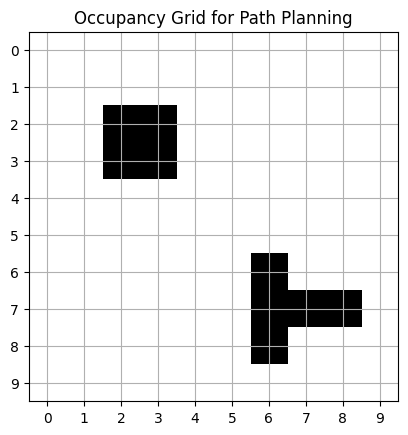

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid size
grid_size = (10, 10)  # 10x10 grid
occupancy_grid = np.zeros(grid_size)

# Mark some obstacles (set 1 for obstacles)
# Example: Creating a block of obstacles
occupancy_grid[2:4, 2:4] = 1  # Obstacle block in (2,2) to (3,3)
occupancy_grid[6:9, 6] = 1    # Vertical obstacle at x = 6
occupancy_grid[7, 7:9] = 1    # Horizontal obstacle at y = 7

# Function to visualize the occupancy grid
def plot_occupancy_grid(grid):
    plt.imshow(grid, cmap='gray_r', origin='upper')
    plt.grid(True)
    plt.xticks(np.arange(grid.shape[1]))
    plt.yticks(np.arange(grid.shape[0]))
    plt.title("Occupancy Grid for Path Planning")
    plt.show()

# Plot the grid
plot_occupancy_grid(occupancy_grid)


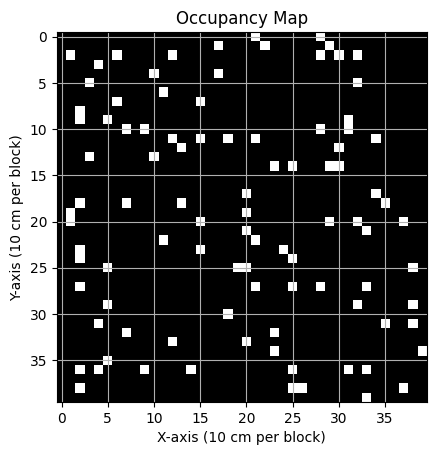

Occupancy map saved as 'occupancy_map.csv'


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the map
field_size_m = 4  # Field size in meters (4x4 meters)
block_size_m = 0.1  # Block size (10x10 cm blocks)
grid_size = int(field_size_m / block_size_m)  # Number of blocks in each dimension (40x40 grid)

# Create a grid with all values initialized to 0 (free space)
occupancy_map = np.zeros((grid_size, grid_size), dtype=int)

# Function to randomly place obstacles on the map
def add_random_obstacles(occupancy_map, num_obstacles):
    for _ in range(num_obstacles):
        x = np.random.randint(0, occupancy_map.shape[0])
        y = np.random.randint(0, occupancy_map.shape[1])
        occupancy_map[x, y] = 1  # Set the obstacle to 1 (occupied)
    return occupancy_map

# Add random obstacles
occupancy_map = add_random_obstacles(occupancy_map, num_obstacles=100)

# Display the occupancy map using matplotlib
plt.imshow(occupancy_map, cmap='gray', origin='upper')
plt.title("Occupancy Map")
plt.xlabel("X-axis (10 cm per block)")
plt.ylabel("Y-axis (10 cm per block)")
plt.grid(True)
plt.show()

# Save the occupancy map to a file (for use by robot systems)
np.savetxt('occupancy_map.csv', occupancy_map, delimiter=',', fmt='%d')

print("Occupancy map saved as 'occupancy_map.csv'")


## How to improve it even more ? 

If you already have a functioning system that can follow a path from point A to point B while avoiding obstacles, you might want to focus on improving accuracy. You may have noticed that not all recorded data leads to precise location estimations, and depending on your strategy, there could be delays in determining the position. However, there is another valuable source of information that can enhance these estimations: the car model. Let’s walk through an example to demonstrate how you can estimate the car's location using the car model, starting from the initial position and orientation.


Imagine you have a simple car model that predicts how the car moves based on steering angle and speed. Let's say the car starts at position (0, 0) facing east (0°), and you give it a command to drive forward at 2 meters per second for 5 seconds, then turn right by 90° and continue for another 3 seconds.

Initial position: (0, 0) with a heading of 0° (east).
After 5 seconds: The car moves 2 m/s × 5 seconds = 10 meters forward. Now, the car is at position (10, 0), still facing east.
Turn command: The car turns 90° right and now faces south (heading 270°).
After 3 more seconds: The car moves another 2 m/s × 3 seconds = 6 meters south. The new position is (10, -6).
So, using the car model (which predicts how the car reacts to speed and turning commands) and the control commands (forward, turn, etc.), you can estimate the car's new position at each step of the movement. However, the car model you have developed is more complex, which means that estimating the car's location likely requires solving a set of differential equations at each iteration. 

Now that you have an additional source of location data, you need to find an intelligent method to determine when and which information to use for your location estimation. This involves combining TDOA data with the car model, which may provide different results. You can develop your own approach, but for guidance and suggestions, refer to the chapter on state tracking.



